# JAX-CFD demo

This initial demonstration shows how to use JAX-CFD to simulate decaying turbulence in 2D.

In [1]:
import jax
import jax.numpy as jnp
import jax_cfd.base as base
import jax_cfd.collocated as collocated
import jax_cfd.data.xarray_utils as xru
import numpy as np
import seaborn
import xarray

funcutils = base.funcutils

In [2]:
def run_collocated(size, seed=0, inner_steps=25, outer_steps=100):
  density = 1.
  viscosity = 1e-3
  max_velocity = 2.0
  cfl_safety_factor = 0.5

  # Define the physical dimensions of the simulation.
  grid = base.grids.Grid((size, size),
                         domain=((0, 2 * jnp.pi), (0, 2 * jnp.pi)))

  # Choose a time step.
  dt = base.equations.stable_time_step(
      max_velocity, cfl_safety_factor, viscosity, grid)

  # Construct a random initial velocity. The `filtered_velocity_field` function
  # ensures that the initial velocity is divergence free and it filters out
  # high frequency fluctuations.
  v0 = collocated.initial_conditions.filtered_velocity_field(
      jax.random.PRNGKey(seed), grid, max_velocity)

  # Define a step function and use it to compute a trajectory.
  # For linear convection, add the argument to semi_implicit_navier_stokes:
  #   `convect=collocated.advection.convect_linear`
  step_fn = funcutils.repeated(
      collocated.equations.semi_implicit_navier_stokes(
          density=density, viscosity=viscosity, dt=dt, grid=grid),
      steps=inner_steps)
  rollout_fn = jax.jit(funcutils.trajectory(step_fn, outer_steps))
  _, trajectory = jax.device_get(rollout_fn(v0))

  # load into xarray for visualization and analysis
  ds = xarray.Dataset(
      {
          'u': (('time', 'x', 'y'), trajectory[0].data),
          'v': (('time', 'x', 'y'), trajectory[1].data),
      },
      coords={
          'x': grid.axes()[0],
          'y': grid.axes()[1],
          'time': dt * inner_steps * np.arange(outer_steps)
      }
  )
  return ds

ds_collocated_256 = run_collocated(size=256)

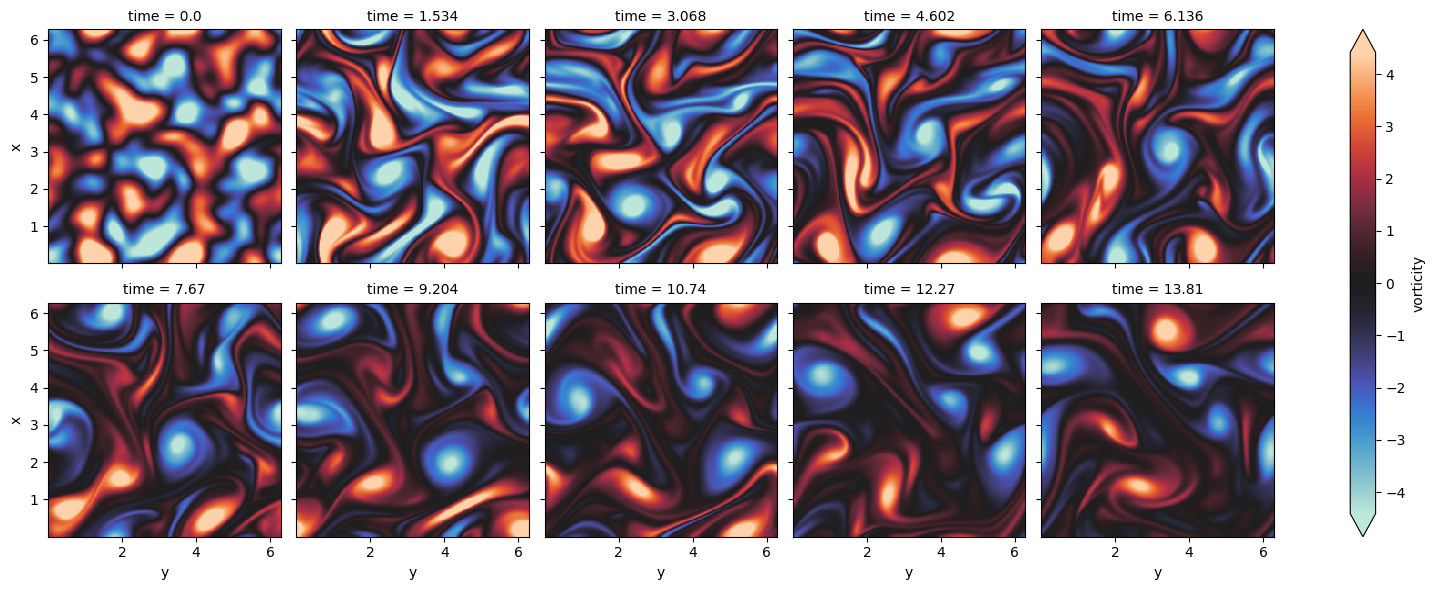

In [3]:
def vorticity(ds):
  return (ds.v.differentiate('x')
          - ds.u.differentiate('y')).rename('vorticity')

(ds_collocated_256.pipe(vorticity).thin(time=10)
.plot.imshow(col='time', cmap=seaborn.cm.icefire, robust=True, col_wrap=5));

## Solve on Staggered Grid and Compare

In [4]:
def run_staggered(size, seed=0, inner_steps=25, outer_steps=100):
  density = 1.
  viscosity = 1e-3
  max_velocity = 2.0
  cfl_safety_factor = 0.5

  # Define the physical dimensions of the simulation.
  grid = base.grids.Grid((size, size),
                         domain=((0, 2 * jnp.pi), (0, 2 * jnp.pi)))

  # Choose a time step.
  dt = base.equations.stable_time_step(
      max_velocity, cfl_safety_factor, viscosity, grid)
  
  # Construct a random initial velocity. The `filtered_velocity_field` function
  # ensures that the initial velocity is divergence free and it filters out
  # high frequency fluctuations.
  v0_staggered = base.initial_conditions.filtered_velocity_field(
      jax.random.PRNGKey(seed), grid, max_velocity)

  # Define a step function and use it to compute a trajectory.
  step_fn_staggered = funcutils.repeated(
      base.equations.semi_implicit_navier_stokes(
          density=density, viscosity=viscosity, dt=dt, grid=grid),
      steps=inner_steps)
  rollout_fn = jax.jit(funcutils.trajectory(step_fn_staggered, outer_steps))
  _, trajectory_staggered = jax.device_get(rollout_fn(v0_staggered))

  # load into xarray for visualization and analysis
  ds_staggered = xarray.Dataset(
      {
          'u': (('time', 'x', 'y'), trajectory_staggered[0].data),
          'v': (('time', 'x', 'y'), trajectory_staggered[1].data),
      },
      coords={
          'x': grid.axes()[0],
          'y': grid.axes()[1],
          'time': dt * inner_steps * np.arange(outer_steps)
      }
  )
  return ds_staggered

ds_staggered_256 = run_staggered(size=256)

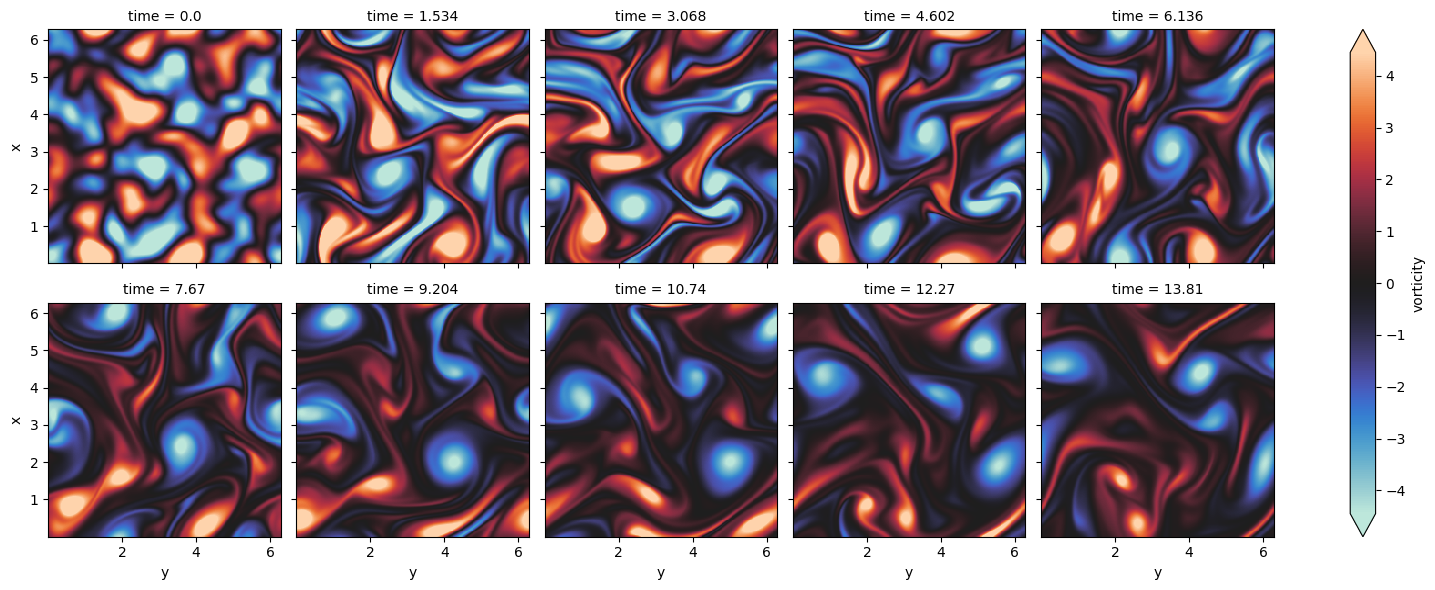

In [5]:
def vorticity(ds):
  return (ds.v.differentiate('x') - ds.u.differentiate('y')).rename('vorticity')

(ds_staggered_256.pipe(vorticity).thin(time=10)
 .plot.imshow(col='time', cmap=seaborn.cm.icefire, robust=True, col_wrap=5));

In [6]:
# Plot the velocity field correlation vs time
def correlation(x, y):
  state_dims = ['x', 'y']
  p  = xru.normalize(x, state_dims) * xru.normalize(y, state_dims)
  return p.sum(state_dims)

correlation(ds_collocated_256, ds_staggered_256).plot.scatter('time', 'v')

KeyError: "No variable named None. Variables on the dataset include ['time', 'u', 'v']"

## Run at higher resolution and compare

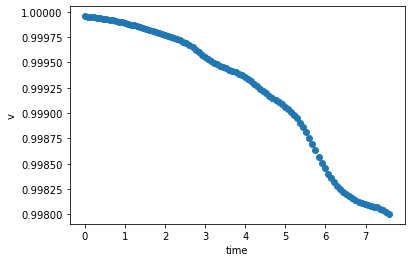

In [ ]:
ds_collocated_512 = run_collocated(size=512)
ds_staggered_512 = run_staggered(size=512)
correlation(ds_collocated_512, ds_staggered_512).plot.scatter('time', 'v')

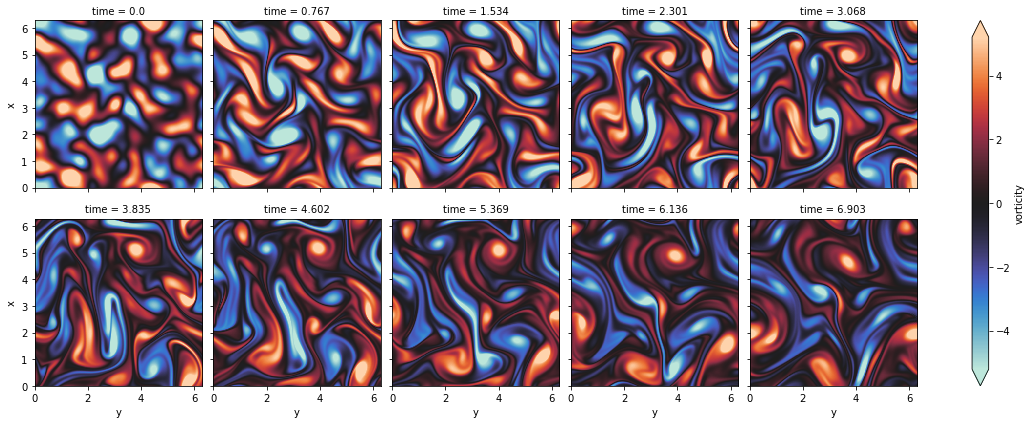

In [ ]:
(ds_collocated_512.pipe(vorticity).thin(time=10)
 .plot.imshow(col='time', cmap=seaborn.cm.icefire, robust=True, col_wrap=5));

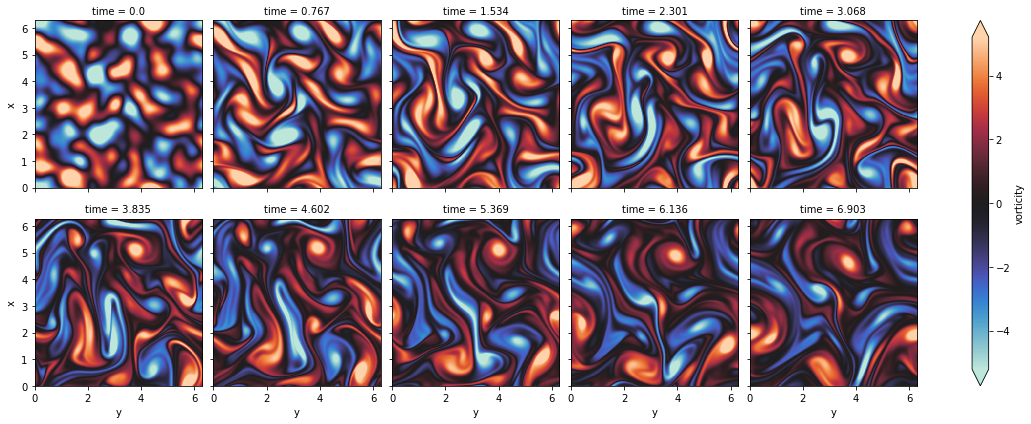

In [ ]:
(ds_staggered_512.pipe(vorticity).thin(time=10)
 .plot.imshow(col='time', cmap=seaborn.cm.icefire, robust=True, col_wrap=5));